In [1]:
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784",version =1)

In [2]:
X = mnist.data
y = mnist.target
y = y.astype(np.uint8) # ! remember that target column is str



X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [4]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3,random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [7]:
from sklearn.model_selection import cross_val_predict
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### Precision : is the accuracy of the positive predictions

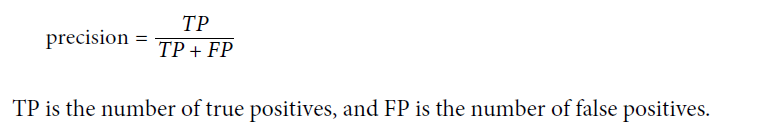

### Recall : called sensitivity , is the ratio of positive instances that are correctly detected by the classifier 

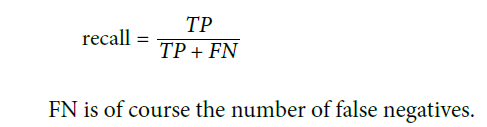

In [13]:
# let's see this scores for our model based on the confusion matrix  (some simple operations)

# variables  
TN = 53892 ; FN = 1891 ; TP = 3530 ; FP = 687

"Precision score is {}".format(TP/(TP+FP)) , "Recalll score is {}".format(TP/(TP+FN))

('Precision score is 0.8370879772350012',
 'Recalll score is 0.6511713705958311')

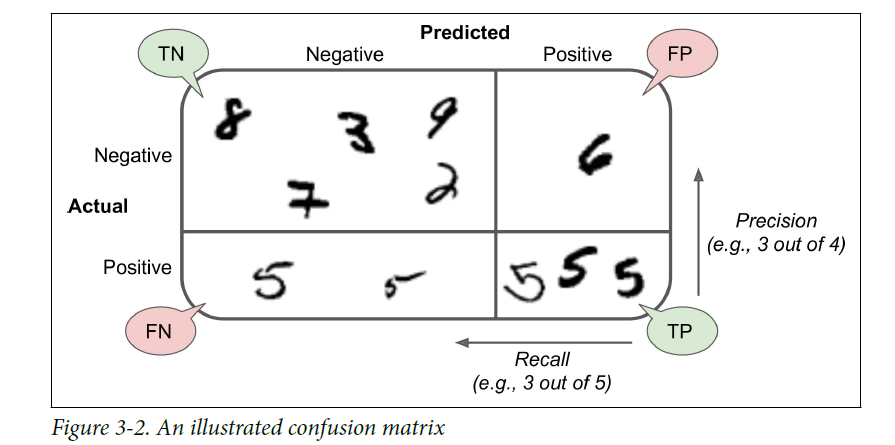

In [14]:
# use sklearn for this scores

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5,y_train_pred) , recall_score(y_train_5,y_train_pred)

(0.8370879772350012, 0.6511713705958311)

 #### When it claims an image represents a 5, it is correct only 83.7 %he time
 #### Moreover it only detects 65.1 %of the 5'
 
 
 ### It is often convenient to combine precision and recall into a single metric called the F1 core, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall
 
 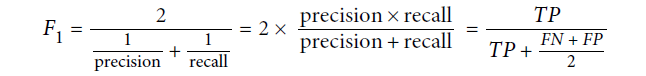

In [15]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

# Precision / Recall Tradeoff

The F1 score favors classifiers that have similar precision and recall. This is not always
what you want: in some contexts you mostly care about precision, and in other contexts
you really care about recall.

    - For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection).
    - On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught). 
    
    
Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall tradeoff.

### Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want

In [19]:
some_digit = X[0]

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

### The algorithm make s a prediction based on this score ... if score > threshold   class 1  else class 0.

Now how do you decide which threshold to use? For this you will first need to get the
scores of all instances in the training set using the cross_val_predict() function
again, but this time specifying that you want it to return decision scores instead of
predictions

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

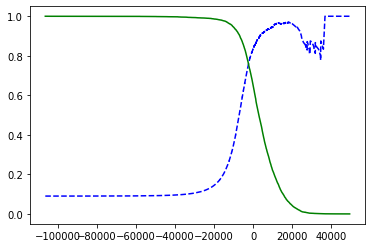

In [25]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

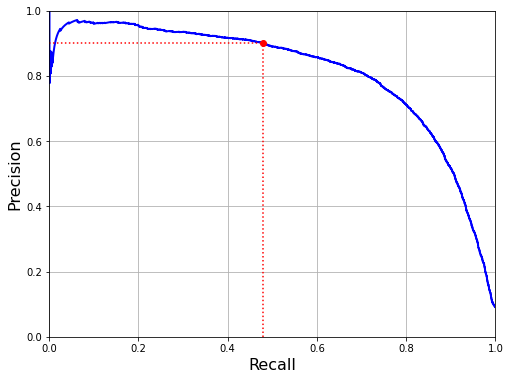

In [28]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

### You can see that precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall tradeoff just before that drop—for example, at around 60% recall. But of course the choice depends on your project.

So let’s suppose you decide to aim for 90% precision. You look up the first plot and
find that you need to use a threshold of about 8,000. To be more precise you can
search for the lowest threshold that gives you at least 90% precision (np.argmax()
will give us the first index of the maximum value, which in this case means the first
True value):

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision   #returns the threshold value for 90 % precision

3370.0194991439557

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision) #map the actual scores to the new threshold
precision_score(y_train_5, y_train_pred_90)  # desired precision

0.9000345901072293

In [31]:
recall_score(y_train_5, y_train_pred_90)  #tradeoff

0.4799852425751706

## As we can see we got a 90 % precision classifier! but this is not very usefull without a decent recall value ( next notebook)